<a href="https://colab.research.google.com/github/fernandofsilva/LSTM_Option_Pricing/blob/main/notebooks/04_modelo_lstm_sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [6]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [7]:
#@title Carregando os dados
data = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes,base
2015-01-05,PETRM17,OPÇÕES DE VENDA,8.18,16.91,2015-01-19,0.039683,8.61,0.771953,0.1157,8.22,100,treino
2015-01-05,PETRM28,OPÇÕES DE VENDA,0.36,8.41,2015-01-19,0.039683,8.61,0.771953,0.1157,0.41,40,treino
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0,teste
2015-01-05,PETRM23,OPÇÕES DE VENDA,0.79,9.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.87,63,treino
2015-01-05,PETRM25,OPÇÕES DE VENDA,1.13,9.61,2015-01-19,0.039683,8.61,0.771953,0.1157,1.16,73,treino


# Pré-processamento LSTM

Essa fase é necessária para o input dos dados na rede LSTM, redes LTSM precisam dos dados em 3 dimensões, porém não existe uma quantidade fixa de dias de negócios para cada opção, para fixar um valor de time steps, foram criados dias em branco com valores 0 para inserir dentro da rede, esses valores não prejudicam o treinamento, uma vez que não existem opções de valores 0.

In [ ]:
#@title Padding time steps

# Reset Index
data = data.reset_index()

# Criar dataframe de referência
reference = data.groupby(['data_vencimento', 'codigo', 'mercado', 'base'], as_index=False).agg({'T': 'count'})

# Dataframe para anexar os dados de cada loop
data_padded = pd.DataFrame()

# Tamanho da maior sequência
max_length = reference['T'].max() #341

# Loop over the reference dict
for index, row in reference.iterrows():

    # Filtrar os dados para uma opção
    subset = data[(data['data_vencimento'] == row['data_vencimento']) & (data['codigo'] == row['codigo'])]

    # Calcular o tamanho dos que serão anexadoss
    size = max_length - subset.shape[0]

    # Criar o dataframe com os dados nulos
    subset = pd.DataFrame({'index': pd.date_range(start='1/1/2010', periods=size),
                'codigo': [row['codigo']] * size,
                'mercado': [row['mercado']] * size,
                'preco_opcao': [0.0] * size,
                'preco_exercicio': [0.0] * size,
                'data_vencimento': [row['data_vencimento']] * size,
                'T': [0.0] * size,
                'preco_ativo': [0.0] * size,
                'volatilidade': [0.0] * size,
                'taxa_juros': [0.0] * size,
                'black_scholes': [0.0] * size,
                'delta_black_scholes': [0] * size,
                'base': [row['base']] * size
    }).append(subset)

    # Anexar o subset dos dados no dataframee
    data_padded = data_padded.append(subset)

# Ordenar valores
data_padded = data_padded.sort_values(by=['data_vencimento', 'codigo', 'index'])

# Colocar index
data_padded.index = data_padded['index']
data_padded = data_padded.drop(['index'], axis=1)

In [8]:
data_padded = pd.read_csv('/content/drive/My Drive/Mestrado/data/dados_padded_treino_teste.csv.gz', compression='gzip')
max_length = 341

# Engenharia das variáveis (Feature Engineering)

Essa sessão é composta da transformação dos dados para entrada na rede na rede neural. Portando, as variáveis são transformadas do seu valor original, seja para adequação dentro da rede neural ou para um melhor treinamento da rede, essas transformações são:

- Variavéis númericas foram normalizadas antes da entrada na rede
- Variável categórica sofreu one hot encoding

A transformação dos dados é feita no mesmo momento que o modelo é treinado, isso é feito através da criacão de um modelo que não diferenciado numéricamente e vai somente processar os dados de entrada. 

In [9]:
#@title Definir subset para o modelo
cols = ['preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros', 'mercado', 'preco_opcao']
features = data[cols].copy()
labels = features.pop('preco_opcao')

In [10]:
#@title Definir variáveis de entrada
inputs = {}

for name, column in features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [11]:
#@title Definir variáveis númericas e normalizar
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype==tf.float32}

x = tf.keras.layers.Concatenate(name='concatenate_numeric')(list(numeric_inputs.values()))
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(np.array(data[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

preprocessed_inputs = [all_numeric_inputs]

In [12]:
#@title Definir categóricas e aplicar one hot encoding
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
  
    lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=np.unique(features[name]))
    one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

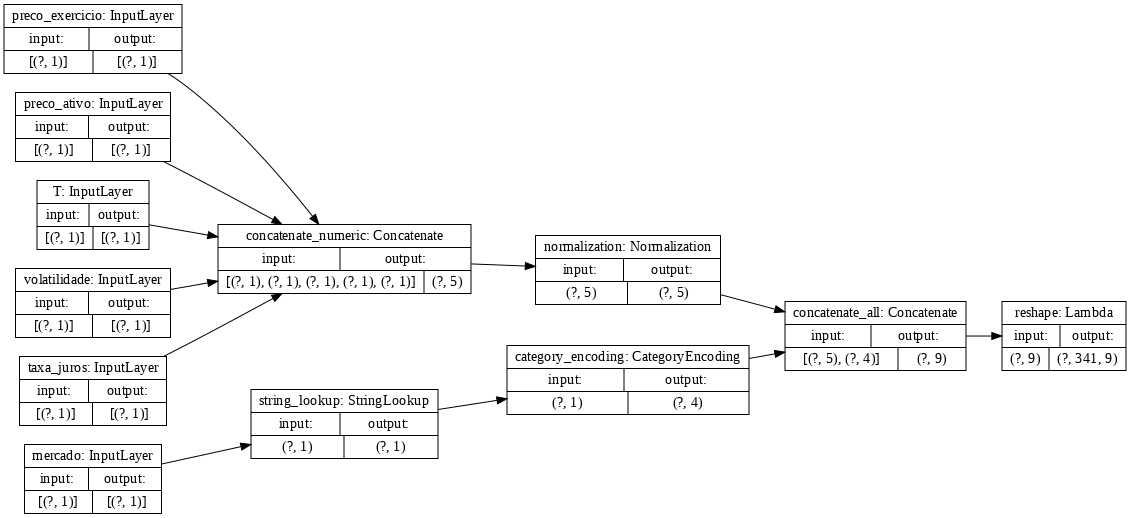

In [53]:
#@title Concatenar dados de entrada e criar modelo para processamento das variavéis
preprocessed_inputs_cat = tf.keras.layers.Concatenate(name='concatenate_all')(preprocessed_inputs)
reshape_inputs = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, 341, 9)), name='reshape')(preprocessed_inputs_cat)
model_preprocessing = tf.keras.Model(inputs, reshape_inputs)
tf.keras.utils.plot_model(model=model_preprocessing, rankdir="LR", dpi=72, show_shapes=True)

In [54]:
#@title Amostra de dados processados
sample_features_dict = {name: np.array(value) for name, value in features.items()}
sample_features_dict = {name: values[:341] for name, values in sample_features_dict.items()}
model_preprocessing(sample_features_dict)

<tf.Tensor: shape=(1, 341, 9), dtype=float32, numpy=
array([[[-0.16609144, -1.262118  , -0.5997047 , ...,  0.        ,
          0.        ,  1.        ],
        [-1.2128178 , -1.262118  , -0.5997047 , ...,  0.        ,
          0.        ,  1.        ],
        [-1.6438228 , -1.262118  , -0.5997047 , ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.7202407 , -1.3005961 , -0.2999    , ...,  0.        ,
          1.        ,  0.        ],
        [-1.0170184 , -1.3005961 ,  4.989511  , ...,  0.        ,
          1.        ,  0.        ],
        [-0.8938741 , -1.3005961 ,  4.989511  , ...,  0.        ,
          1.        ,  0.        ]]], dtype=float32)>

In [60]:
#@title tf.Data
def df_to_dataset(dataframe, base, shuffle=True, batch_size=22, timesteps=341):

    dataframe = dataframe.copy()
    dataframe = dataframe[dataframe['base'] == base]
    labels = dataframe.pop('preco_opcao')
    cols = ['mercado', 'preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros']
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[cols]), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds.batch(batch_size*timesteps)

# Divisão da base de treino e teste
train_ds = df_to_dataset(data, base='treino')
test_ds = df_to_dataset(data, shuffle=False, base='teste')

# Modelo

O modelo de rede neural profunda a seguir, foi baseado nos estudos desenvolvidos por Hirsa, Karatas, & Oskoui. No trabalho são testadas diversas arquiteturas (camadas e elementos em cada camada), bem como função de atição de cada camada e também função de otimização.

A conclusão do estudo mostra que os melhores resultados foram obtidos utilizando uma rede de 4 camadas com 120 neurônios cada uma.

In [ ]:
#@title Camada customizada
class ReshapeEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(ReshapeEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.mae_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, logits, targets=None, sample_weight=None):
        if targets is not None:
            # Compute the training-time loss value and add it
            # to the layer using `self.add_loss()`.
            loss = self.loss_fn(targets, logits, sample_weight)
            self.add_loss(loss)

            # Log the accuracy as a metric (we could log arbitrary metrics,
            # including different metrics for training and inference.
            self.add_metric(self.accuracy_fn(targets, logits, sample_weight))

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)

In [55]:
#@title Criar, compilar o modelo
# Define de model
def get_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.LSTM(40, return_sequences=True),
        tf.keras.layers.LSTM(40, return_sequences=True),
        tf.keras.layers.Dense(1)
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='mse',
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="MAE", dtype=None)]
    )

    return model

model = get_model(model_preprocessing, inputs)

In [64]:
#@title Callbacks
# Tensorflow checkpoint
path = '/content/drive/MyDrive/Mestrado/models/lstm/'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'checkpoint',
    frequecy='epoch',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2, min_delta=0.001, patience=5, verbose=1)

csv = tf.keras.callbacks.CSVLogger(path+"results.csv")

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1)

In [65]:
#@title Treinar o modelo
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=200,
    callbacks=[checkpoint, lr, csv, es]
    )

Epoch 1/200


InvalidArgumentError: ignored

In [ ]:
#@title Métricas
metrics = pd.read_csv(path + 'results.csv')
metrics.head()

In [ ]:
#@title Plot das Métricas do Modelo

# Valor de mudança de learning rate
metrics['lr_change'] = metrics['lr'] == metrics['lr'].shift(1)

# Valores de learning para plot de gráfico
lr_change = metrics.loc[metrics['lr_change'] == False, ['epoch', 'lr']]

# Retirar a primeira linha
lr_change = lr_change[1:]

# Converter para dict
lr_change = lr_change.to_dict('records')

# Create two subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(metrics['epoch'], metrics['loss'], 'tab:blue', label='treino')
axs[0].plot(metrics['epoch'], metrics['val_loss'], 'tab:red', label='teste')
axs[0].set_title('Função de Perda')
axs[0].set(ylabel='Perda')
axs[0].legend()

axs[1].plot(metrics['epoch'], metrics['MAE'], 'tab:blue', label='treino')
axs[1].plot(metrics['epoch'], metrics['val_MAE'], 'tab:red', label='teste')
axs[1].set_title('Erro Médio Absoluto')
axs[1].set(ylabel='MAE')
axs[1].legend()

for lr in lr_change:
    axs[0].axvline(x=lr['epoch'], linestyle='dotted', color='black')
    axs[1].axvline(x=lr['epoch'], linestyle='dotted', color='black')
    axs[0].text(
        x=lr['epoch'],
        y=0.1,
        s=f"lr reduzido para: {lr['lr']:.8f}",
        horizontalalignment='right'
        )
    axs[1].text(
        x=lr['epoch'],
        y=0.17,
        s=f"lr reduzido para: {lr['lr']:.8f}",
        horizontalalignment='right'
        )

for ax in axs.flat:
    ax.set(xlabel='Épocas')

for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
#@title Carregar o melhor modelo
model = get_model()
model.load_weights(path+'checkpoint')

# Predição na base de teste
prediction = model.predict(test_ds)

In [ ]:
#@title Salvar predição
np.savez_compressed('/content/drive/My Drive/Mestrado/data/predicao_lstm.npz', prediction)